In [1]:
import pandas as pd
import numpy as np
import sklearn
import faiss

import spacy

# nlp = spacy.load('en_core_web_md')

from sentence_transformers import SentenceTransformer
import scipy.spatial

import pickle

In [23]:
def load_df(course_type):
    # course_type: credit course or online course
    # credit f21: take in free_text_f_21.csv
    # credit w22: take in free_text_w_22.csv
    # online course: take in online df
    
    if course_type == 'Fall 2021':
        df = pd.read_csv('C:/Users/hEBE2/assets/free_text_f_21.csv')
        corpus = df['text'].tolist()
        corpus_embeddings_file = 'C:/Users/hEBE2/assets/corpus_embeddings_f_21.pkl'
        embedder_file = 'C:/Users/hEBE2/assets/embedder_f_21.pkl'
        
    elif course_type == 'Winter 2022':
        df = pd.read_csv('C:/Users/hEBE2/assets/free_text_w_22.csv')
        corpus = df['text'].tolist()
        corpus_embeddings_file = 'C:/Users/hEBE2/assets/corpus_embeddings_w_22.pkl'
        embedder_file = 'C:/Users/hEBE2/assets/embedder_w_22.pkl'
        
    elif course_type == 'online':
        df = pd.read_csv('C:/Users/hEBE2/assets/original/2021-10-19-MichiganOnline-courses.csv')
        corpus = df['description'].tolist()
        corpus_embeddings_file = 'C:/Users/hEBE2/assets/corpus_embeddings_online.pkl'
        embedder_file = 'C:/Users/hEBE2/assets/embedder_online.pkl'
        
    return df, corpus_embeddings_file, embedder_file, corpus

In [24]:
def load_sentence_transformer(course_type):
    # course_type: credit course or online course
    # credit course: take in free_text_fw.csv
    # online course: take in online df
    
    df, corpus_embeddings_file, embedder_file, corpus = load_df(course_type)

    #Load sentences & embeddings from disc
    with open(corpus_embeddings_file, "rb") as fIn:
        stored_data = pickle.load(fIn)
        stored_corpus = stored_data['corpus']
        stored_embeddings = stored_data['embeddings']

    with open(embedder_file, "rb") as fIn:
        stored_embedder = pickle.load(fIn)
        
    return df, stored_data, stored_corpus, stored_embeddings, stored_embedder, corpus

In [28]:
df, stored_data, stored_corpus, stored_embeddings, stored_embedder, corpus = load_sentence_transformer('Fall 2021')

In [30]:
def recommender(course_type, queries, k):
    # query free text input from user about his interest
    # we want to see k nearest neighbors of query
    
    df, stored_data, stored_corpus, stored_embeddings, stored_embedder, corpus = load_sentence_transformer(course_type)

    d= 768
    index = faiss.IndexFlatL2(d)
    index.add(np.stack(stored_embeddings, axis=0))   

    query_embeddings = stored_embedder.encode(queries)
    D, I = index.search(query_embeddings, k)     # actual search


    df_1 = df[['course', 'Course Title','description']]
    res = [df_1.iloc[I[i]] for i in range(len(queries))]

    l_dis = []
    for query, query_embedding in zip(queries, query_embeddings):
        distances, indices = index.search(np.asarray(query_embedding).reshape(1,768),k)        
        l_dis.append([distances[0,idx] for idx in range(0,k)])

    return(res, l_dis)

    '''
    for query, query_embedding in zip(queries, query_embeddings):
        distances, indices = index.search(np.asarray(query_embedding).reshape(1,768),k)
        print("\n======================\n")
        print("Query:", query)
        print("\nTop 5 most similar sentences in corpus:")
        for idx in range(0,k):
            print(corpus[indices[0,idx]], "(Distance: %.4f)" % distances[0,idx])
    '''

In [31]:
queries =["I am interested in computer science",
         "I like pop music", 
        "I like Asian culture, especially Janpanese history", 
        "I like to use computer skill to resolve biological problems"]
recommender('Fall 2021', queries, 5)

([         course          Course Title  \
  1423   EECS 198        Special Topics   
  4092     SI 710  Research Sem in Info   
  123     ALA 118   Prog, Info & People   
  1515   EECS 699    Research Work EECS   
  4098  SIADS 501  Being Data Scientist   
  
                                              description  
  1423  Topics of current interest selected by the fac...  
  4092                                                NaN  
  123   Introduction to programming with a focus on ap...  
  1515                                                NaN  
  4098                                                NaN  ,
             course          Course Title  \
  4532       TO 415  Advan Excel with VBA   
  520      BCOM 430  Positive Communicatn   
  1611  ENGLISH 319     Lit&Social Change   
  2960    MUSED 121     Tech for Music Ed   
  2966    MUSED 478  Comm Engage Music Ed   
  
                                              description  
  4532                                       

In [32]:
# list of dfs 
dfs = recommender('Fall 2021', queries, 5)[0]

# list of distance 
dis = recommender('Fall 2021', queries, 5)[1]

In [35]:
import matplotlib.pyplot as plt
def vis(df, dis, title):
    fig, ax = plt.subplots()

    ax.set_xticks(range(len(dis)))
    ax.set_xticklabels(list(df['Course Title']), minor=False, rotation=45)
    ax.plot(dis, linewidth=2.0)
    plt.title('Distance to'+' '+ "'"+ title +"'")

    plt.show()

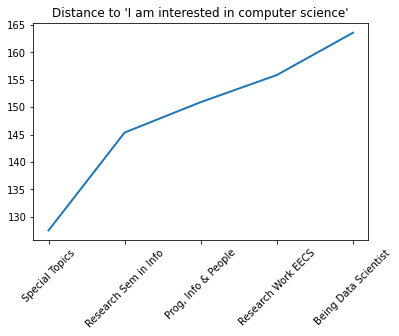

In [37]:
vis(dfs[0], dis[0], queries[0])

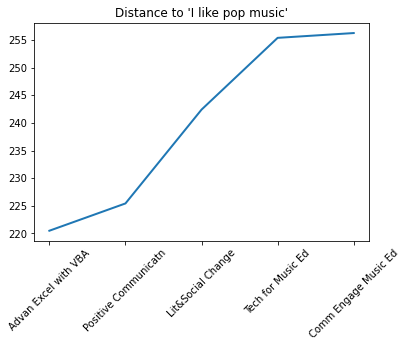

In [38]:
vis(dfs[1], dis[1], queries[1])

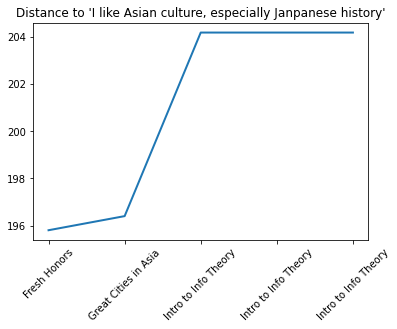

In [39]:
vis(dfs[2], dis[2], queries[2])

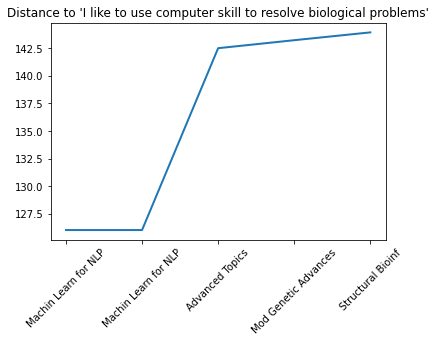

In [40]:
vis(dfs[3], dis[3], queries[3])